<a href="https://colab.research.google.com/github/gulamhus/pmi-vs-btc-cycle-analysis/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

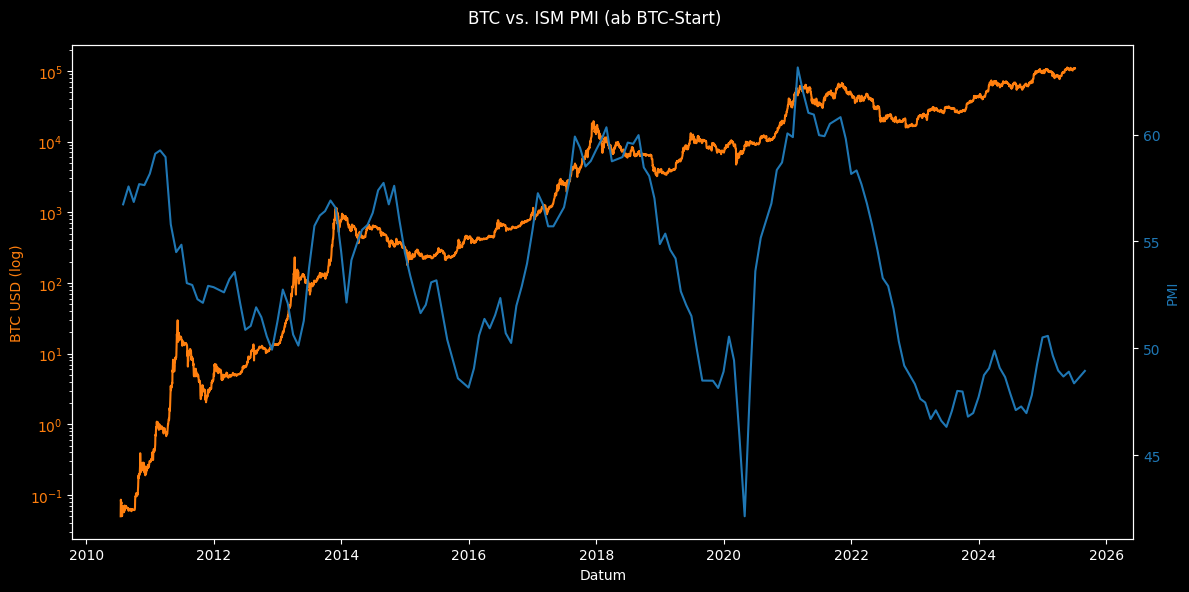

In [15]:
# import pythen libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import ipywidgets as widgets
from ipywidgets import interact

# 1) load bitcoin history and pmi history
url_btc = "https://raw.githubusercontent.com/gulamhus/pmi-vs-btc-cycle-analysis/main/bitcoin_2010-07-17_2025-07-06.csv"
url_m2  = "https://raw.githubusercontent.com/gulamhus/pmi-vs-btc-cycle-analysis/main/pmi.csv"

# 2) clear both datasets
df_btc = pd.read_csv(
    url_btc,
    parse_dates=['Start'],
    index_col='Start'
)

df = pd.read_csv(url_m2)   # Pfad anpassen

# Jahr und Bruchteil aufsplitten bei pmi
year = np.floor(df["Year"]).astype(int)
frac = df["Year"] - year

# Jahr-Dezimal → Monat
month = (np.floor(frac * 12).astype(int) + 1).clip(1, 12)

# Monatliches Datum erstellen (Monatsende für Konsistenz mit pmi/BTC)
dt = pd.to_datetime(dict(year=year, month=month, day=1)) + pd.offsets.MonthEnd(0)

# DataFrame mit sauberen Index
ism_m = pd.DataFrame({"PMI": df["pmi"].values}, index=dt)
ism_m.index.name = "Date"

# Falls mehrere Werte pro Monat: mitteln
ism_m = ism_m.groupby(level=0).mean().sort_index()


# 3) Plot mit beiden Reihen (BTC + getrimmter PMI)
# Startdatum von BTC
btc_start = df_btc.index.min()


# PMI auf BTC-Beginn trimmen
ism_trimmed = ism_m.loc[ism_m.index >= btc_start]


fig, ax1 = plt.subplots(figsize=(12,6))

# BTC links (log)
color = "tab:orange"
ax1.set_xlabel("Datum")
ax1.set_ylabel("BTC USD (log)", color=color)
ax1.plot(df_btc.index, df_btc["Close"], color=color, label="BTC")
ax1.set_yscale("log")
ax1.tick_params(axis="y", labelcolor=color)

# PMI rechts (linear, getrimmt)
color = "tab:blue"
ax2 = ax1.twinx()
ax2.set_ylabel("PMI", color=color)
ax2.plot(ism_trimmed.index, ism_trimmed["PMI"], color=color, label="PMI")
ax2.tick_params(axis="y", labelcolor=color)

fig.suptitle("BTC vs. ISM PMI (ab BTC-Start)")
fig.tight_layout()
plt.show()


In [14]:

#analyse
s = ism_trimmed["PMI"].copy()   # monatliche PMI-Serie ab BTC-Start

# fit sinus kurve afu pmi mit fixer mittlerer Amplitude
C_global = s.mean()
# robuste Amplitude: halbe 5–95%-Spannweite (statt max-min, um Ausreißer zu entschärfen)
A_global = 0.5 * (s.quantile(0.95) - s.quantile(0.05))

# 2) Hilfsfunktionen
def years_since(t_index, t0):
    return (t_index - t0).days / 365.25

def sine_with_params(t_years, P, phi, A=A_global, C=C_global):
    return C + A * np.sin(2*np.pi * (t_years / P) + phi)

def fit_segment_fixed_A_C(seg, P_range=(3.0, 5.0), nP=81, nPhi=360):
    """
    Fit mit fester Amplitude A_global und Offset C_global.
    Sucht bestes (P, phi) per Grid-Search, minimiert MSE im Segment.
    """
    t = years_since(seg.index, seg.index[0])
    y = seg.values

    P_grid   = np.linspace(P_range[0], P_range[1], nP)
    phi_grid = np.linspace(0, 2*np.pi, nPhi, endpoint=False)

    best = {"mse": np.inf, "P": None, "phi": None, "yhat": None}
    for P in P_grid:
        # vorab sin/cos nicht nötig – direkt auswerten reicht
        for phi in phi_grid:
            yhat = sine_with_params(t, P, phi)
            mse  = np.mean((y - yhat)**2)
            if mse < best["mse"]:
                best.update({"mse": mse, "P": P, "phi": phi, "yhat": yhat})
    return best

def plot_fit(start_year, end_year):
  # --- 1) Trainingsfenster & voller Zeitraum ---
  window_start_str = f"{start_year}-01"
  window_end_str = f"{end_year}-01"
  s_train = s.loc[window_start_str:window_end_str].dropna()
  s_full  = s.dropna()


  # --- 2) Fit (P & phi) nur auf Trainingsfenster; A/C bleiben global ---
  best = fit_segment_fixed_A_C(s_train, P_range=(3.5, 5.0), nP=41, nPhi=180)
  print(f"P≈{best['P']:.2f} Jahre, phi≈{best['phi']:.2f} rad, MSE(train)={best['mse']:.3f}")

  # Vorhersage über gesamten Zeitraum
  t_full = years_since(s_full.index, s_train.index[0])  # wichtig: gleiches t0 wie im Training!
  yhat_full = sine_with_params(t_full, best["P"], best["phi"])

  # zurückliegend pmi tops während der letzten Bullruns
  local_pmi_peaks = [
      "2011-02-20",
      "2013-10-20",
      "2018-02-20",
      "2021-02-20"
  ]

  # Blow-off-Top-Daten (Beispiele – trage hier deine genauen Dates ein)
  blowoff_dates = pd.to_datetime([
      "2011-06-15",
      "2013-12-04",
      "2017-12-20",
      "2021-04-14",
  ])


  # --- 3) Plot: BTC links (log), PMI rechts + eine Sinus-Kurve ---
  fig, ax1 = plt.subplots(figsize=(12,6))
  plt.style.use("dark_background")

  # BTC (links)
  ax1.plot(df_btc.index, df_btc["Close"], color="tab:orange", label="BTC")
  ax1.set_yscale("log")
  ax1.set_ylabel("BTC USD (log)", color="tab:orange")
  ax1.tick_params(axis="y", labelcolor="tab:orange")

  # historische pmi tops während bullruns einzeichnen
  local_pmi_peaks = pd.to_datetime(local_pmi_peaks)
  for i, d in enumerate(local_pmi_peaks):
      label = "local PMI-Tops during bullruns" if i == 0 else "_nolegend_"
      ax1.axvline(
          d, linestyle="--", alpha=0.33, linewidth=4,
          color="tab:blue", label=label
      )

  # Rauten auf der x-Achse platzieren
  xtrans = ax1.get_xaxis_transform()
  ax1.scatter(
      blowoff_dates,
      [0.02]*len(blowoff_dates),      # 2 % über der Achse
      marker="D", s=100,
      color="tab:orange", alpha=0.9,
      zorder=5, transform=xtrans,
      clip_on=False,
      label="Blowofftop dates"
  )

  # PMI (rechts)
  ax2 = ax1.twinx()
  line_pmi, = ax2.plot(s_full.index, s_full.values, color="tab:blue", label="PMI")

  # Sinus: Training gestrichelt
  line_fit_full, = ax2.plot(
      s_full.index, yhat_full, linestyle="--", linewidth=8, alpha=0.33,
      color="tab:blue", label="Sinus-fit auf PMI bis 2020"
  )

  ax2.set_ylabel("PMI", color="tab:blue")
  ax2.tick_params(axis="y", labelcolor="tab:blue")

  # Jahres-Ticks
  ax1.xaxis.set_major_locator(mdates.YearLocator(1))
  ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
  fig.autofmt_xdate()

  # eine gemeinsame Legende links oben
  lines1, labels1 = ax1.get_legend_handles_labels()
  lines2, labels2 = ax2.get_legend_handles_labels()
  ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

  fig.suptitle("PMI — fitted Sine — BTC Price", fontsize=33)
  plt.tight_layout()
  plt.show()


# Interaktives Widget
start_slider   = widgets.IntSlider(min=2010, max=2021, step=1, value=2010,
                                 description="Sinus Fitting auf PMI ab Jahr", continuous_update=False)
end_slider   = widgets.IntSlider(min=2014, max=2025, step=1, value=2023,
                                 description="Sinus Fitting auf PMI bis Jahr", continuous_update=False)


widgets.interact(plot_fit, start_year=start_slider, end_year=end_slider);


interactive(children=(IntSlider(value=2010, continuous_update=False, description='Sinus Fitting auf PMI ab Jah…